<a href="https://colab.research.google.com/github/Kallol7/PytorchNotes/blob/main/Pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from transformers import AutoModel, AutoFeatureExtractor, AutoModel, AutoConfig
import os

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import albumentations as A
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T

In [2]:
# !pip install torcheval
from torcheval.metrics import MulticlassAccuracy, AUC

In [209]:
# https://huggingface.co/zongzhuofan/co-detr-vit-large-coco/resolve/main/pytorch_model.pth

from huggingface_hub import hf_hub_download

REPO_ID = "zongzhuofan/co-detr-vit-large-coco"
FILENAME = "pytorch_model.pth"

model_path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME, local_dir ="model")

In [210]:
# model_path = "/content/model/pytorch_model.pth"
checkpoint = torch.load(
    model_path, weights_only=False
)

In [275]:
model_path = "/content/model"
os.rename(f"{model_path}/pytorch_model.pth", f"{model_path}/pytorch_model.bin")

In [598]:
model_config = AutoConfig.from_pretrained(REPO_ID)

In [719]:
model_config

DetrConfig {
  "_name_or_path": "zongzhuofan/co-detr-vit-large-coco",
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "attention_dropout": 0.0,
  "auxiliary_loss": false,
  "backbone": "resnet50",
  "backbone_config": null,
  "backbone_kwargs": {
    "in_chans": 3,
    "out_indices": [
      1,
      2,
      3,
      4
    ]
  },
  "bbox_cost": 5,
  "bbox_loss_coefficient": 5,
  "class_cost": 1,
  "d_model": 256,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 2048,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "dice_loss_coefficient": 1,
  "dilation": false,
  "dropout": 0.1,
  "encoder_attention_heads": 8,
  "encoder_ffn_dim": 2048,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_coefficient": 0.1,
  "giou_cost": 2,
  "giou_loss_coefficient": 2,
  "init_std": 0.02,
  "init_xavier_std": 1.0,
  "is_encoder_decoder": true,
  "mask_loss_coefficient": 1,
  "model_type": "detr",
  "num_channels": 3,
  "num_hidden_layers": 6,
  "num_queries": 100,
  "p

In [ ]:
pretrained_model = AutoModel.from_pretrained(model_path, config = model_config)

In [721]:
# height, width don't matter
random_batch = torch.randn(5,3, 190, 190)
pretrained_model.eval()
pretrained_model(random_batch).last_hidden_state.shape

torch.Size([5, 100, 256])

In [722]:
len(list(pretrained_model.children()))

5

In [723]:
lenght_of_child_of_children = [len(list(child.children())) for child in pretrained_model.children()]
lenght_of_child_of_children

[2, 0, 0, 1, 2]

In [724]:
# from google.colab import drive
# drive.mount('/content/drive')

In [725]:
# !unzip "/content/drive/MyDrive/Colab Notebooks/Dog Breed Classification/dog_breed.zip" -d "/content"

In [726]:
DATA_DIR = "/content/"
DEVICE = "cuda"
BATCH_SIZE = 6
HEIGHT, WIDTH = (200,200)
TOTAL_CLASS = 3
LR = 1e-5
EPOCHS = 500
MODEL_SAVE_PATH = "best.pt"

In [727]:
df = pd.read_csv("dogs.csv")
df.head(2)

,filepaths,labels,data set
0,train/Afghan/001.jpg,Afghan,train
1,train/Afghan/002.jpg,Afghan,train


In [728]:
# typo fix
df["labels"] = df["labels"].apply(lambda x: "American Spaniel" if x == "American  Spaniel" else x)

class_to_num = {label:name for (name,label) in enumerate(df["labels"].unique())}
class_name = {num:name for (name,num) in class_to_num.items()}

print("{")
for i in range(5):
  print(f"  {i}: {class_name[i]}")
print("}")

{
  0: Afghan
  1: African Wild Dog
  2: Airedale
  3: American Hairless
  4: American Spaniel
}


In [729]:
df["labels"] = df["labels"].apply(lambda x:class_to_num[x])
df = df.iloc[:,:2]
df.head(3)

,filepaths,labels
0,train/Afghan/001.jpg,0
1,train/Afghan/002.jpg,0
2,train/Afghan/003.jpg,0


In [730]:
# only using 5 class
df = df[df["labels"]<TOTAL_CLASS]
df.labels.unique()

array([0, 1, 2])

In [731]:
train_df, test_df = train_test_split(df, test_size=0.20, random_state=42, stratify=df["labels"])
len(train_df), len(test_df)

(312, 79)

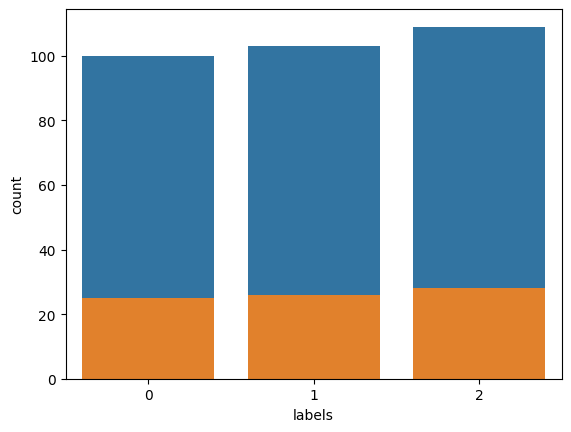

In [732]:
sns.countplot(data=train_df, x="labels")
sns.countplot(data=test_df, x="labels")
plt.show()

# Sample Image

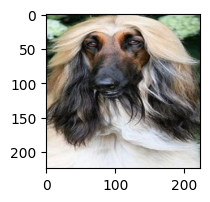

(224, 224, 3)

In [733]:
img = Image.open(os.path.join(DATA_DIR, train_df.iloc[5,0]))
_, ax = plt.subplots(1,1, figsize=(2,2))
ax.imshow(img)
plt.show()
np.shape(img)

# Augmentation

In [734]:
train_augms = A.Compose([
    A.Rotate(limit = (-90,90)),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomResizedCrop(scale = (.45,1.0), size = (HEIGHT,WIDTH)),
    A.Normalize(mean = (.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

valid_augms = A.Compose([
    A.Resize(height=HEIGHT, width=WIDTH),
    A.Normalize(mean = (.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

def denorm(channel_first_tensor_image):
  return channel_first_tensor_image.permute(1,2,0) * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))

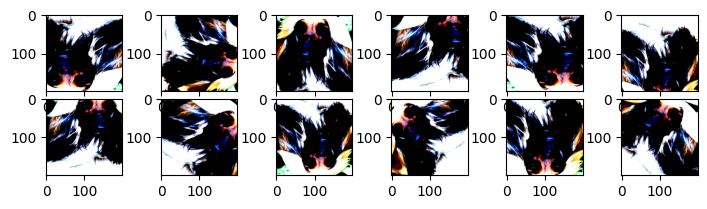

In [735]:
import logging

def show_image(img, aumentation = None, title = None, ax = None, plt_show = True, figsize=(8,8)):
  logger = logging.getLogger()
  old_level = logger.level
  logger.setLevel(100)

  if ax is None:
    if aumentation is not None:
      _, axes = plt.subplots(2,6,figsize=figsize)
      plt.subplots_adjust(left=0, bottom=0, right=0.85, top=0.2, wspace=0.1, hspace=0.1)

      for ax in axes.flatten():
        ax.imshow( aumentation(image = np.array(img))['image'] )
    else:
        plt.figure(figsize=(2,2))
        plt.imshow(img)

  else: # ax is provided
      ax.imshow( np.array(img) )

  if title is not None:
    if ax is None:
      plt.title(title)
    else:
      ax.set_title(title)

  if plt_show:
    plt.show()

  logger.setLevel(old_level)

show_image(img, train_augms)

# Load Dateset

In [736]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, directory, transforms=None):
        super().__init__()
        self.dataframe = dataframe
        self.data_dir = directory
        self.transforms = transforms

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = os.path.join(self.data_dir, self.dataframe.iloc[index, 0])
        image = Image.open(img_path)

        label = self.dataframe.iloc[index, 1]

        if self.transforms:
          image = self.transforms(image=np.array(image))['image']

        """Converts PIL or ndarray (H x W x C) range[0, 255]
        to a torch.FloatTensor (C x H x W) range [0.0, 1.0]"""
        image = T.ToTensor()(image)

        return image, label

In [737]:
# Create datasets
train_ds = ImageDataset(train_df, DATA_DIR, train_augms)
valid_ds = ImageDataset(test_df, DATA_DIR, valid_augms)

train_ds[43][0].shape, valid_ds[33][0].shape

(torch.Size([3, 200, 200]), torch.Size([3, 200, 200]))

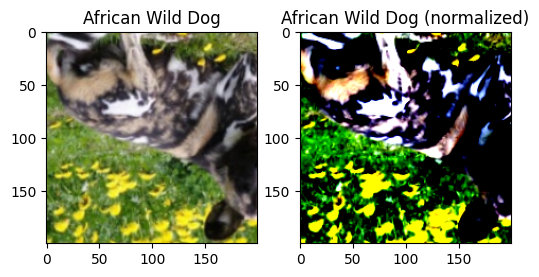

In [738]:
_channel_first_img,_label = train_ds[23]

_, ax = plt.subplots(1,2, figsize=(6,6))
ax = ax.flatten()

show_image(denorm(_channel_first_img), title = f"{class_name[_label]}", ax = ax[0], plt_show=False)
show_image(_channel_first_img.permute(1,2,0), title = f"{class_name[_label]} (normalized)", ax=ax[1])

In [739]:
print(f"Total training images {len(train_ds)}")
print(f"Total validation images {len(valid_ds)}")

Total training images 312
Total validation images 79


# Dataloader

In [740]:
train_dloader = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle=True)
valid_dloader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)

print(f"Total batch in train loader : {len(train_dloader)}")
print(f"Total batch in valid loader : {len(valid_dloader)}")

Total batch in train loader : 52
Total batch in valid loader : 14


# Model

In [741]:
class Model(nn.Module):
  def __init__(self, pretrained, num_of_class = TOTAL_CLASS):
    super().__init__()

    self.hidden = pretrained
    del(pretrained)

    self.maxpool = nn.MaxPool2d(kernel_size=(14,14), stride=4)

    self.classifier = nn.Sequential(
        nn.Flatten(start_dim=1),
        nn.Linear(1342, 700),
        nn.BatchNorm1d(700),
        nn.ReLU(),
        nn.Dropout(0.5),

        nn.Linear(700, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.3),

        nn.Linear(256, num_of_class)
    )

  def forward(self, images):
    x = self.hidden(images).last_hidden_state
    x = self.maxpool(x)
    x = self.classifier(x)

    return x

In [742]:
# https://spandan-madan.github.io/A-Collection-of-important-tasks-in-pytorch/

cnt = 1
for child in pretrained_model.children():
    if cnt <= 4:
        print("child ",cnt," was frozen")
        for param in child.parameters():
            param.requires_grad = False
    elif cnt == 5:
        cnt_children_of_child = 1
        inner_cnt = len(list(child.children()))
        for children_of_child in child.children():
            if cnt_children_of_child < inner_cnt:
                for param in children_of_child.parameters():
                    param.requires_grad = False
                print('child ', cnt_children_of_child, 'of child',cnt,' was frozen')
            else:
                print('child ', cnt_children_of_child, 'of child',cnt,' was not frozen')
            cnt_children_of_child += 1

    # else:
    #     print("child ",cnt," was not frozen")
    cnt += 1

child  1  was frozen
child  2  was frozen
child  3  was frozen
child  4  was frozen
child  1 of child 5  was frozen
child  2 of child 5  was not frozen


In [743]:
model = Model(pretrained_model)
print(model(torch.randn(6,3,120,120)).shape)

torch.Size([6, 3])


## Training & Validation Functions

In [744]:
def train_fn(dataloader, model, optimizer, criterion, device = DEVICE):
  model.train()
  total_loss = 0
  for images, labels in tqdm(dataloader, total = len(dataloader)):
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    logits = model(images)

    loss = criterion(logits, labels)
    total_loss += loss.item()

    loss.backward()
    optimizer.step()

  return total_loss/len(dataloader)

In [745]:
def evel_fn(dataloader, model, criterion, metric, device = DEVICE):
  model.eval()

  metric.reset()
  total_loss = 0

  for images, labels in tqdm(dataloader, total = len(dataloader)):
    images = images.to(device)
    labels = labels.to(device)

    logits = model(images)
    loss = criterion(logits, labels)
    metric.update(torch.argmax(logits, dim=-1), labels)
    total_loss += loss.item()

  return total_loss/len(dataloader), metric.compute().item()

# Training

In [746]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
metric = MulticlassAccuracy(average = "macro", num_classes=70)

best_validation_loss = float("inf")
epoch = 0

# resume training
if os.path.exists(MODEL_SAVE_PATH):
  checkpoint = torch.load(MODEL_SAVE_PATH, weights_only=True)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  best_validation_loss = checkpoint['best_validation_loss']

In [747]:
%%capture
# "cuda", for gpu
device = "cpu"

# device = DEVICE # gpu
model.to(device)

In [ ]:
for i in range(EPOCHS):
  train_loss = train_fn(train_dloader, model, optimizer, criterion, device=device)
  validation_loss, macro_avg_accuracy = evel_fn(valid_dloader, model, criterion, metric, device=device)

  epoch += 1

  if validation_loss < best_validation_loss:
    best_validation_loss = validation_loss

    torch.save({
      'epoch': int(epoch),
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'best_validation_loss': best_validation_loss,
      'macro_avg_accuracy': macro_avg_accuracy
    }, MODEL_SAVE_PATH)

  print(f"Epoch: {epoch} Train_Loss: {train_loss:0.8f} Val_Loss: {validation_loss:0.8f}, Macro_Avg_Accuracy: {macro_avg_accuracy:0.8f}")

100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


Epoch: 1 Train_Loss: 1.17603858 Val_Loss: 1.11840350, Macro_Avg_Accuracy: 0.35047618


100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


Epoch: 2 Train_Loss: 1.17920789 Val_Loss: 1.17560754, Macro_Avg_Accuracy: 0.33333334


 12%|█▏        | 6/52 [00:10<01:14,  1.61s/it]

In [ ]:
# Reload the best model
checkpoint = torch.load(MODEL_SAVE_PATH, weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

print(f"Epoch: {checkpoint['epoch']}, best_validation_loss: {best_validation_loss}, macro_avg_accuracy: {checkpoint['macro_avg_accuracy']}")